In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
batch_size=1
fitter=list()
evaluator=list()
!pip install dicom
!pip install pydicom
import dicom
!pip install matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
history=list()
!pip install keras
from keras.models import load_model
from __future__ import division
import pydicom
from io import BytesIO
from sklearn.preprocessing import normalize
import google.datalab.storage as storage
import matplotlib.pyplot as plt
from skimage import filters
from scipy.ndimage.interpolation import rotate
import math
import numpy as np
from sklearn.metrics import accuracy_score

!pip install h5py
import h5py
import keras 
from keras import layers 
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization,Conv3D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from scipy.ndimage.interpolation import zoom
from keras.layers import Flatten,Dense
from keras.utils import to_categorical
import keras.losses
import keras.backend as back
from keras.backend import int_shape
from keras.callbacks import ModelCheckpoint
class msa:
  def initialize(self):
    self.replay=0
    self.replay2=0
    bucket = storage.Bucket('fifth-honor-201613')
    obj = bucket.object('stage1_labels.csv')
    csv_file=obj.read_stream()
    #loading dependent variable and id data
    df=pd.read_csv(BytesIO(csv_file))
    df=df.sort_values(['cancer'])
    self.total=list()
    self.train=list()
    self.valid=list()
    self.test=list()
   #loading path name to images and id data 
    for o in storage.Bucket('fifth-honor-201613').objects(prefix='adiroybuck',delimiter=''):
        self.total.append(str(o.key).split('/')[1])
    self.total=list(set(self.total))
   #sorting data
    self.total=sorted(self.total)
    y=np.array(df['cancer'])
    self.total=pd.DataFrame(self.total,columns=['id'])
    #merging images and dependent variable by id column
    self.total=self.total.merge(df,how='left',on='id')   
    self.total_na=self.total.isnull().sum()
    self.total=self.total.fillna(0)
    if self.total.shape[1]>2:
        self.total.drop(columns=[x for x in t.columns[2:]],inplace=True)
    self.total=self.total.iloc[1:,:]
    #train and test split of merged dataset 
    self.train,self.test=train_test_split(self.total.iloc[1:,:],test_size=0.66,random_state=42)
    #valid and test split of merged dataset 
    self.valid,self.test=train_test_split(self.test,test_size=0.5,random_state=42)
    self.train.reset_index(drop=True,inplace=True)
    self.test.reset_index(drop=True,inplace=True)
    self.valid.reset_index(drop=True,inplace=True)
    repeat='notfoo'
    #building a CNN neural network
    try:
      #building a model
      self.model=Sequential()
      self.model.add(Conv3D(30,(30),padding='same',activation='relu',data_format='channels_first',input_shape=(1,50,128,128)))
      self.model.add(Conv3D(40,(30),padding='same',activation='relu',data_format='channels_first'))
      keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=None, padding='same', data_format=(1,50,128,128))
      self.model.add(Conv3D(1,(15),padding='same',activation='relu',data_format='channels_first'))
      self.model.add(Flatten())
      self.model.add(Dense(2,activation='softmax'))
      self.model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
      i=0 
      #loading weights from the previous iteration
      self.model.load_weights=self.model.load_weights('weights.hdf5')
    except:
      #loading the previous model
      self.model=load_model('new.h5')
      #checkpointing new weights
      self.checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1)   
  #check if the input data into the function is to be trained or tested, if it should be trained or valid check=notfoo, if it should be tested then check=foo 
  def array_generator(self,train):
    if self.train.loc[0,'id']==self.test.loc[0,'id']:
      check='foo'
    else:
      check='notfoo'
    train_y=self.train['cancer'].values
    self.test_y=self.test['cancer'].values
    train_y=to_categorical(train_y,num_classes=2)
    while 1: 
      y=list()
      ordered_position=list()
      plan0=list()
      b=list()
      for i in range(1,len(self.train)):
        slices=list()
        patient=list()
        position=list()
        patient_images=list()
        #dicom files or .dcm files of each patient
        patient=[o.key for o in storage.Objects('fifth-honor-201613',prefix='adiroybuck/'+str(self.train.loc[i,'id'])+'/',delimiter='')]
        #sorting the dicom files of each patient by their slice location
        for j in range(len(patient)):
          bucket = storage.Bucket('fifth-honor-201613')
          obj = bucket.object(patient[j])
          dicom_file=obj.read_stream()
          df=dicom.read_file(BytesIO(dicom_file))
          position.append(df.SliceLocation)
        sor=sorted(position)
        ran=[sor.index(x) for x in position]
        o=0
        v=[0 for x in range(len(patient))]
        for x in ran:
          v[x]=patient[o]
          o=o+1
        patient=v
        #reading the sorted dicom files and removing the edges and noise from the ct scan or images
        for j in range(len(patient)):
          bucket = storage.Bucket('fifth-honor-201613')
          obj = bucket.object(patient[j])
          dicom_file=obj.read_stream()
          df=dicom.read_file(BytesIO(dicom_file))
          ordered_poistion=df.ImageOrientationPatient
          pixel_Array=df.pixel_array
          val=filters.threshold_otsu(pixel_Array)
          mask=pixel_Array>val
          pixel_Array=mask*pixel_Array
          pixel_Array=normalize(pixel_Array,axis=1)
          slices.append(pixel_Array)
        #stacking the sorted arrays
        threed_array=np.stack([x for x in slices],axis=0)
        threed_array=scipy.ndimage.zoom(threed_array,1/4,order=0)

        threed_array=np.expand_dims(threed_array,axis=0)
        threed_array=np.expand_dims(threed_array,axis=0)
        if threed_array.shape[2]>=50:
          threed_array=threed_array[:,:,:50,:,:]
        else:
          temp=threed_array
          m=threed_array.shape[2]
          threed_array=np.zeros((1,1,50,128,128))
          threed_array[0,:,:m,:,:]=temp
        #  if it is either validated data or test data just return the array
        if check=='foo':
          #print('test')

          self.replay=self.replay+1
          print(self.replay)
          
          yield(threed_array)
        #if it is a train data return arrays and the target variable  
        else:
          self.replay2=self.replay2+1
          
          print(self.replay2)

          yield(threed_array,np.expand_dims(train_y[i],0))

  #function will return a model by using the return value from array_generator. generator function with necessary arguments is used to build the model and the model is saved         
  def second_func(self):
    if True:
      return self.model.fit_generator(self.array_generator(self.train),validation_data=self.array_generator(self.valid),callbacks=[self.checkpointer],use_multiprocessing=True,steps_per_epoch=np.round(len(self.train)/batch_size),epochs=5,verbose=1)
import warnings
warnings.filterwarnings('ignore')
msa_instance=msa()
msa_instance.initialize()
history=msa_instance.second_func()
print('a')


You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/usr/local/envs/py3env/lib/python3.5/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Epoch 1/5
1
2
1/5 [=====>........................] - ETA: 2:32:42 - loss: 16.0302 - acc: 0.0000e+003
4
2/5 [===========>..................] - ETA: 1:39:08 - loss: 8.0151 - acc: 0.5000     5
6
4/5 [=======================>......] - ETA: 30:16 - loss: 4.0076 - acc: 0.7500  8
9
5/5 [==============================] - 8802s 1760s/step - loss: 6.4121 - acc: 0.6000

Epoch 00001: saving model to weights.hdf5
Epoch 2/5
10
11
2/5 [===========>..................] - ETA: 1:23:32 - loss: 1.0960e-07 - acc: 1.000013


Traceback (most recent call last):
  File "/usr/local/envs/py3env/lib/python3.5/site-packages/keras/utils/data_utils.py", line 678, in _data_generator_task
    self.queue.put((True, generator_output))
  File "<string>", line 2, in put
  File "/usr/local/envs/py3env/lib/python3.5/multiprocessing/managers.py", line 716, in _callmethod
    conn.send((self._id, methodname, args, kwds))
  File "/usr/local/envs/py3env/lib/python3.5/multiprocessing/connection.py", line 206, in send
    self._send_bytes(ForkingPickler.dumps(obj))
  File "/usr/local/envs/py3env/lib/python3.5/multiprocessing/connection.py", line 397, in _send_bytes
    self._send(header)
  File "/usr/local/envs/py3env/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Process Process-2:
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/l

KeyboardInterrupt: 

In [1]:
# evaluate_generator
evaluator=list()
evaluator.append(msa_instance.model.evaluate_generator(msa_instance.array_generator(msa_instance.train),steps=len(msa_instance.train)/batch_size))

NameError: name 'evaluator' is not defined

In [151]:
#predict_geneator
predictions=list()
predictions.append(msa_instance.model.predict_generator(msa_instance.array_generator(msa_instance.test),steps=len(msa_instance.test),verbose=1))

8
9
5/5 [==============================] - 6240s 1248s/step
14


In [152]:
print(predictions)

[array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)]


In [2]:
from sklearn.metrics import accuracy_score
accurcy_score(predictions[:,1],msa_instance.test_y)

0.6


In [6]:
print(msa_instance.model.layers[0].get_weights()[0].shape)
print(msa_instance.model.layers[1].get_weights()[0].shape)
print(msa_instance.model.layers[2].get_weights()[0].shape)

(30, 30, 30, 1, 30)
(30, 30, 30, 30, 60)
(15, 15, 15, 60, 1)


In [ ]:
# just to see weights and observing the image
#observing sample 
#####################################sample###############################
slices=list()
patient=list()
position=list()
patient_images=list()
patient=[o.key for o in storage.Objects('fifth-honor-201613',prefix='adiroybuck/'+str(msa_instance.train.loc[0,'id'])+'/',delimiter='')]
for j in range(len(patient)):
  bucket = storage.Bucket('fifth-honor-201613')
  obj = bucket.object(patient[j])
  dicom_file=obj.read_stream()
  df=dicom.read_file(BytesIO(dicom_file))
  position.append(df.SliceLocation)
sor=sorted(position)
ran=[sor.index(x) for x in position]
o=0
v=[0 for x in range(len(patient))]
for x in ran:
  v[x]=patient[o]
  o=o+1
patient=v
for j in range(len(patient)):
  bucket = storage.Bucket('fifth-honor-201613')
  obj = bucket.object(patient[j])
  dicom_file=obj.read_stream()
  df=dicom.read_file(BytesIO(dicom_file))
  ordered_poistion=df.ImageOrientationPatient
  pixel_Array=df.pixel_array
  val=filters.threshold_otsu(pixel_Array)
  mask=pixel_Array>val
  pixel_Array=mask*pixel_Array
  slices.append(pixel_Array)
  threed_array=np.stack([x for x in slices],axis=0)
  threed_array=scipy.ndimage.zoom(threed_array,1/4,order=0)
        
  threed_array=np.expand_dims(threed_array,axis=0)
  threed_array=np.expand_dims(threed_array,axis=0)
  if threed_array.shape[2]>=50:
    threed_array=threed_array[:,:,:50,:,:]
  else:
    temp=threed_array
    m=threed_array.shape[2]
    threed_array=np.zeros((1,1,50,128,128))
    threed_array[0,:,:m,:,:]=temp

In [7]:
###################################################        sample              #######################
layers= msa_instance.model.layers
inputs = msa_instance.model.input                                          
outputs = [layer.output for layer in layers]
real = back.function([inputs]+ [back.learning_phase()], outputs ) 
test = threed_array
result = real([test, 1.])

In [120]:
###################################################        sample              #######################
msa_instance.model.layers[1].get_weights()

[array([[[[[ 1.09634221e-01,  6.39452860e-02,  7.34545523e-04, ...,
            -1.12083275e-03,  8.75398219e-02,  4.68696691e-02],
           [ 1.44176736e-01,  8.58689770e-02,  1.04661635e-03, ...,
             1.28858560e-03,  1.17567837e-01,  5.84285855e-02],
           [ 7.44350180e-02,  4.52542529e-02,  4.70903527e-04, ...,
             1.12868939e-03,  5.66677600e-02,  3.51854265e-02],
           ...,
           [ 1.43121496e-01,  8.60336646e-02, -1.76490546e-04, ...,
            -1.09601114e-03,  1.16264008e-01,  5.94901703e-02],
           [ 1.04080737e-01,  6.16061576e-02,  5.56265004e-04, ...,
            -1.13270667e-04,  8.16189125e-02,  4.62216958e-02],
           [ 8.78093839e-02,  5.46333268e-02, -9.97707830e-04, ...,
            -1.56221772e-03,  6.81318045e-02,  3.93616669e-02]],
 
          [[ 1.09437786e-01,  6.36898428e-02,  7.23358302e-04, ...,
            -6.62571751e-04,  8.69325846e-02,  4.78065088e-02],
           [ 1.44047782e-01,  8.49500299e-02,  1.02585100

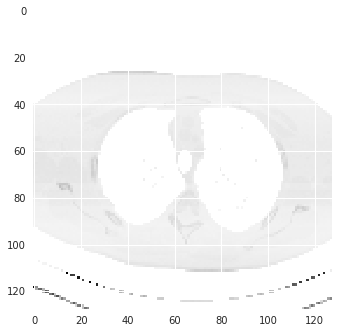

In [105]:
###################################################        sample              #######################
plt.imshow(threed_array[0,0,10,:,:])

In [163]:
###################################################        sample              #######################
msa_instance.test['id']

0    7bfba4540956c0b2c5b78b3623a4855d
1    4a782bbc2608288a3ed05e511af6f8bb
2    0a38e7597ca26f9374f8ea2770ba870d
3    2ce2565b9839d8812cf0f9ad80371d3f
4    006b96310a37b36cccb2ab48d10b49a3
Name: id, dtype: object

In [ ]:
###################################################        sample              #######################
self.model=self.model.load_weights('weights.hdf5')

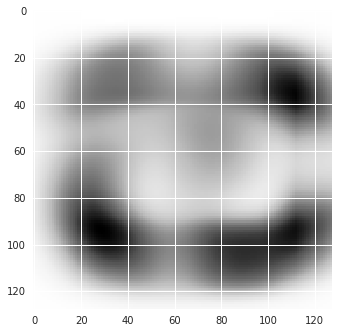

In [24]:
###################################################        sample              #######################
plt.imshow(result[1][0,0,30,:,:])